In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import math
# import scipy.sparse as sps

In [11]:
path='/usr/people/out/Documents/Japan'
kabels=pd.read_csv(path+'/spreadsheetcables.csv', delimiter = ';')
trafo=pd.read_csv(path+'/spreadsheettrafo.csv', delimiter = ';')

###### make some matrices #######
trafo_connect=np.zeros((len(trafo),len(trafo))) #connectivity trafo
trafo_all_connections=np.zeros((len(trafo),len(kabels))) #connections possible between trafo and every cable
trafo_cond=np.zeros((len(trafo),len(trafo))) # The conductivity matrix
stat_heading=np.zeros((len(trafo),len(trafo))) #heading stations to another
stat_length=np.zeros((len(trafo),len(trafo))) #length between stations
stat_voltN=np.zeros((len(trafo),len(trafo))) #voltage in North direction between stations
stat_voltE=np.zeros((len(trafo),len(trafo))) #voltage in east direction between stations
I_GICcable=np.zeros((len(trafo),len(trafo))) #GIC between stations(= through cables)

kabel_resist=np.zeros(len(kabels))
kabel_cond=np.zeros(len(kabels)) #gives total conductivity per connected cable segment per cable
total_kabel_cond=np.zeros(len(kabels)) #gives total conductivity per segment for all cables
aantal_kabels=np.zeros(len(kabels)) #aantal kabels (per fase) per traject
station_lat=np.zeros(len(trafo)) #latitude stations in degrees
station_lon=np.zeros(len(trafo)) #longitude stations in degrees
station_rlat=np.zeros(len(trafo)) #now in radians
station_rlon=np.zeros(len(trafo))
volt_result=np.zeros(len(trafo)) # resulting voltage in nodes
ground_cond=np.zeros(len(trafo))

cable_icon=np.zeros(len(kabels)) # icon array for cable and trafo resp.
trafo_icon=np.zeros(len(trafo))

################ Determine inducted currents ######################
# heading=np.zeros(len(kabels))
# length=np.zeros(len(kabels))

J_north=np.zeros(len(trafo))
J_east=np.zeros(len(trafo))

# set electric field at 1V/1000m for now in North and East direction 
E_north=1/1000.
E_east=1/1000.

###################################################################
##### connect trafo and cable number to position in matrix #####
for line in range(len(kabels)):
    cable_icon[line]=kabels.at[line,'kabelnr']
for line in range(len(trafo)):
    trafo_icon[line]=trafo.at[line,'trafonr']


##### make trafo-trafo connectivity matrix ###### CORRECT
for line in range(len(trafo)): 
    temp=trafo.at[line,'verbonden trafo'] #get right column
    temp=temp.split(",") #split values
    
    for item in temp:
        temp2=int(item)
        trafo_connect[line,np.where(trafo_icon == temp2)[0]]=True #check for connection other trafo
        del temp2
    del temp

###### make trafo-cable connectivity matrix ###### CORRECT
#all connection
for line in range(len(trafo)):
    temp=trafo.at[line,'alle aansluitingen']
    temp=temp.split(",")
    for item in temp:
        temp2=int(item)
        trafo_all_connections[line,np.where(cable_icon == temp2)[0]]=True
        del temp2
    del temp
    
###### make total conductivity vector for cables####### CORRECT
for line in range(len(kabels)):
    kabel_cond[line]=float(kabels.at[line,'conductivity'])
    kabel_resist[line]=1/kabel_cond[line]
for line in range(len(kabels)):
#     aantal_kabels[line]=1
    aantal_kabels[line]=kabels.at[line,'kab/3'] #get amount of cables per traject
    total_kabel_cond[line]=aantal_kabels[line]*kabel_cond[line] #conductivity per cabletraject
    

##### now conductivity matrix ##### 
for row,line in enumerate(trafo_connect):
    station_lat[row]=trafo.at[row,'lat'] # get trafostation latitude and longitude
    station_lon[row]=trafo.at[row,'lon'] 
    station_rlat[row]=np.radians(station_lat[row]) #get trafostation latitude and longitude in radians
    station_rlon[row]=np.radians(station_lon[row])
        
    for column,item in enumerate(line):
        if item:
            
            temp=trafo_all_connections[row,:]+trafo_all_connections[column,:]
            temp2=0
            
            for counter,value in enumerate(temp):
                if value == 2: # if 2 then we have found the connecting cables
                    temp2+=1/total_kabel_cond[counter]  #because of serieschain we have to add 1/sigma
            if temp2==0:
                print(row,column)
            trafo_cond[row,column]=-1/temp2 #add cable resistance to off-diagonal
            trafo_cond[row,row]+=1/temp2 #add cable resistance to trace
            del temp, temp2

# add grounding conductivity to trace            
for line in range(len(trafo_connect)):
    ground_cond[line]=trafo.at[line,'conductivity total']
    trafo_cond[line,line]+=trafo.at[line,'conductivity total']
    
    
################### total induced currents for stationary field ##########################
for row,line in enumerate(trafo_connect): #get heading and length between stations
    for column,item in enumerate(line):
        if item and column>=row:
            temp=math.cos(station_rlat[column])*math.sin(station_rlon[column]-station_rlon[row])
            temp2=math.cos(station_rlat[row])*math.sin(station_rlat[column])-math.sin(station_rlat[row])*math.cos(station_rlat[column])*math.cos(station_rlon[column]-station_rlon[row])
            stat_heading[row,column]=np.abs(math.degrees(math.atan(temp/temp2)))
            
            temp3=math.sin((station_rlat[column]-station_rlat[row])/2.)**2+math.cos(station_rlat[row])*math.cos(station_rlat[column])*math.sin((station_rlon[column]-station_rlon[row])/2.)**2
            stat_length[row,column]=6371000*2*math.atan(np.sqrt(temp3)/np.sqrt(1-temp3))
            
            stat_heading[column,row]=stat_heading[row,column]
            stat_length[column,row]=stat_length[row,column]

for row,line in enumerate(trafo_connect):
    for column,item in enumerate(line):
        if item:            # get voltage between stations
            signlat=np.sign(station_lat[row]-station_lat[column])
            signlon=np.sign(station_lon[row]-station_lon[column])
            stat_voltN[row,column]=signlat*E_north*np.cos(math.radians(stat_heading[row,column]))*stat_length[row,column]
            stat_voltE[row,column]=signlon*E_east*np.sin(math.radians(stat_heading[row,column]))*stat_length[row,column]
            
            J_north[row]+=stat_voltN[row,column]*trafo_cond[row,column]*-1*-1 #-1*-1 because trafo_cond is negative
            J_east[row]+=stat_voltE[row,column]*trafo_cond[row,column]*-1*-1 # and 1V/km N = x A in southern direction
            
J_total=J_north+J_east

##### Apply the inversion #####
trafo_icond=np.linalg.inv(trafo_cond)
Volt_result=np.linalg.solve(trafo_cond,J_east)
I_GIC=Volt_result*ground_cond # GIC ground NIET DELEN
# print(Volt_result, I_GIC)

for row,line in enumerate(trafo_connect):
    for column,item in enumerate(line):
        if item and column>=row:
            I_GICcable[row,column]=(Volt_result[row]-Volt_result[column])*trafo_cond[row,column]*-1
            I_GICcable[column,row]=-1*I_GICcable[row,column]
print(np.sum(I_GIC))

2.0905499553691698e-13


In [12]:
absAMP=abs(I_GIC[0:-3])
# maxAMP=np.max(absAMP) #amperes for 1 cm
maxAMP=30
print(maxAMP)
print(I_GIC)
##### Save files #######
GIC=pd.DataFrame(columns=['lon','lat','GIC',f'GIC/{maxAMP}'])
# GIC=pd.DataFrame(columns=['lon','lat','GIC','Name',])
GICmatrix=pd.DataFrame()
for i in range(len(trafo_connect)):
    GIC.at[i,'lon']=station_lon[i]
    GIC.at[i,'lat']=station_lat[i]
    GIC.at[i,'GIC']=I_GIC[i]
    GIC.at[i,f'GIC/{maxAMP}']=I_GIC[i]/maxAMP
#     GIC.at[i,f'Name']=trafo.at[i,'naam']
    GICmatrix[i]=I_GICcable[i,:]
GIC.to_csv(path_or_buf=f'{path}/GIC_trafo.csv', sep=';', index=False, header=True)
GICmatrix.to_csv(path_or_buf=f'{path}/GIC_cable.csv', sep=';', index=False, header=False)

30
[-19.03089534  -0.         -21.59783327 -25.98555044 -31.39509389
  -0.         -12.03730772  -5.75532128  -0.         -19.57441114
 -14.9014959   -0.          -0.           1.00477485   6.08904953
  16.62372526   0.          19.93499465  23.38993148   0.
   0.           8.89646604  -0.          -7.83520507 -11.92160448
  -5.29692747  20.10839264  14.68775394  11.43114083  11.17530829
   8.22058639   8.0609575    7.14188881  11.32259664   7.55336094
   0.          -0.30928182   0.           0.        ]


In [13]:
# lim1=np.min(station_lon)-0.75
# lim2=np.max(station_lon)+0.75
# lim3=np.min(station_lat)-0.75
# lim4=np.max(station_lat)+0.75
# lim1=3.3
# lim2=9.6
# lim3=49
# lim4=54
# lim1=3.3
# lim2=7.5
# lim3=50.5
# lim4=54
# lim1=19
# lim2=29
# lim3=59.5
# lim4=67.5
lim1=139.5
lim2=146
lim3=41
lim4=46
legendlon=lim2-0.60
legendlat=lim4-0.1
textlon=legendlon+0.38
textlat=legendlat

scrpath='/usr/people/out/Documents/Scripts/'
legend=open('legend.txt','w+')
legend.write(f'{legendlon} {legendlat} 1 1')
legend.close()
legendtxt=open('legendtext.txt', 'w+')
legendtxt.write(f'{textlon} {textlat} {maxAMP} A')
legendtxt.close()

##### Use GMT to plot GICs ######
direction='East'
proj='-JM15C -P'
lims=f'-R{lim1}/{lim2}/{lim3}/{lim4}'
psfile=f'{path}/Japan{direction}.ps' #aanpassen
pngfile=f'{path}/Japan{direction}.png' #aanpassen
os.system(f'gmt pscoast {proj} {lims} -W0.5p -K -Ggrey -Slightblue -Df -N1/0.25p> {psfile}' )
os.system(f'gmt psbasemap {proj} {lims} -Ba1g1 -BWeSn+t"GIC {direction}" -O -K>> {psfile}' )
# os.system(f'gmt psxy {path}/trafo.csv {proj} {lims} -Ss0.1c -Wblack -O -K>> {psfile}')
os.system(f'gmt psxy {path}/GIC_trafo.csv {proj} {lims} -C{scrpath}topo.cpt -Scc -O -K>> {psfile}')
# os.system(f'gmt psxy {path}/cables220.csv {proj} {lims} -W0.5p -Wred -O -K>> {psfile}' )
os.system(f'gmt psxy {path}/cables.csv {proj} {lims} -W0.5p -Wred -O -K>> {psfile}' )
os.system(f'gmt psxy legend.txt {proj} {lims} -C{scrpath}topo.cpt -W -Scc -O -K>> {psfile}')
os.system(f'gmt pstext legendtext.txt {proj} {lims} -F+f20pHelvetica,black -O>> {psfile}')
# os.system(f'convert -density 300 {psfile} {pngfile}')

0

In [5]:
os.system(f'convert -density 300 {psfile} {pngfile}')

134

In [9]:
pwd

'/usr/people/out/Documents/Scripts/partial_code'

In [44]:
# obtain real voltages per cable piece and execute total code
import os
import pandas as pd
import numpy as np
import math
import logging
from scipy.interpolate import griddata
from threading import local
localvar=local()
from multiprocessing import Process
from multiprocessing import Lock
lock=Lock()
path='/usr/people/out/Documents/Magnetic_field/station_results/31-10-2003'
logging.basicConfig(filename=f'{path}/GIClogbook.log', level=logging.DEBUG, format='%(asctime)s %(message)s')
#################################### first reading in datasets #####################################################
try:
    os.mkdir(f'{path}/GIC')
except:
    logging.warning("Directory has already been created, data could be destroyed!")
    print("Directory has already been created, data could be destroyed!")
logging.info('Reading in datasets!')
Electric_Xfiles=[]
Electric_Yfiles=[]
os.system(f' ls {path}/electric_field_north/*.csv > {path}/temp.txt')
f=open(f'{path}/temp.txt')
for item in f:
    item=item.strip('\n')
    Electric_Xfiles.append(item)
f.close()
os.system(f' ls {path}/electric_field_east/*.csv > {path}/temp.txt')
f=open(f'{path}/temp.txt')
for item in f:
    item=item.strip('\n')
    Electric_Yfiles.append(item)
f.close()
os.system(f'rm {path}/temp.txt')

for counter,file in enumerate(Electric_Xfiles):
    Xfile=pd.read_csv(file, delimiter=' ', header=None)
    values=Xfile.to_numpy()
    break
EX_matrix=np.zeros((len(Electric_Xfiles),len(values)))    
EY_matrix=np.zeros((len(Electric_Xfiles),len(values)))
    
for counter,file in enumerate(Electric_Xfiles):
    Xfile=pd.read_csv(file, delimiter=' ', header=None)
    values=Xfile.to_numpy()
    EX_matrix[counter,:]=values[:,2]
lat=values[:,1]
lon=values[:,0]
for counter,file in enumerate(Electric_Yfiles):
    Yfile=pd.read_csv(file, delimiter=' ', header=None)
    values=Yfile.to_numpy()
    EY_matrix[counter,:]=values[:,2]
del item, f, Xfile, values, Yfile

######################################### Getting the needed GIC matrices and code #################################
logging.info('Starting with the GIC code!')
path2='/usr/people/out/Documents/380+220kV_extended'
kabels=pd.read_csv(path2+'/spreadsheetcables.csv', delimiter = ';')
trafo=pd.read_csv(path2+'/spreadsheettrafo.csv', delimiter = ';')
trafo_connect=np.zeros((len(trafo),len(trafo))) #connectivity trafo
trafo_all_connections=np.zeros((len(trafo),len(kabels))) #connections possible between trafo and every cable
trafo_cond=np.zeros((len(trafo),len(trafo))) # The conductivity matrix
stat_heading=np.zeros((len(trafo),len(trafo))) #heading stations to another
stat_length=np.zeros((len(trafo),len(trafo))) #length between stations
station_lat=np.zeros(len(trafo)) #latitude stations in degrees
station_lon=np.zeros(len(trafo)) #longitude stations in degrees
ground_cond=np.zeros(len(trafo))
cable_icon=np.zeros(len(kabels)) # icon array for cable and trafo resp.
trafo_icon=np.zeros(len(trafo))

##### connect trafo and cable number to position in matrix #####
for line in range(len(kabels)):
    cable_icon[line]=kabels.at[line,'kabelnr']
for line in range(len(trafo)):
    trafo_icon[line]=trafo.at[line,'trafonr']
##### make trafo-trafo connectivity matrix ######
for line in range(len(trafo)): 
    temp=trafo.at[line,'verbonden trafo'] #get right column
    temp=temp.split(",") #split values
    
    for item in temp:
        temp2=int(item)
        trafo_connect[line,np.where(trafo_icon == temp2)[0]]=True #check for connection other trafo
        del temp2
    del temp
###### make trafo-cable connectivity matrix ######
for line in range(len(trafo)):
    temp=trafo.at[line,'alle aansluitingen']
    temp=temp.split(",")
    for item in temp:
        temp2=int(item)
        trafo_all_connections[line,np.where(cable_icon == temp2)[0]]=True
        del temp2
    del temp
###### make conductivity matrix ######
for row,line in enumerate(trafo_connect):
    trafo_cond[row,row]=trafo.at[row,'conductivity total']
    for column,item in enumerate(line):
        if item:
            temp=trafo_all_connections[row,:]+trafo_all_connections[column,:]
            temp2=0
            for counter,value in enumerate(temp):
                if value == 2: # if 2 then we have found the connecting cables
                    temp2+=1/(float(kabels.at[counter,'conductivity'])*kabels.at[counter,'kab/3'])  #because of serieschain we have to add 1/sigma
#             if temp2==0:
#                 print(row,column)
            trafo_cond[row,column]=-1/temp2 #add cable resistance to off-diagonal
            trafo_cond[row,row]+=1/temp2 #add cable resistance to trace
            del temp, temp2
###### get heading and length between stations #####
for row,line in enumerate(trafo_connect):
    for column,item in enumerate(line):
        if item and column>=row:
            Alat=np.radians(trafo.at[row,'lat'])
            Alon=np.radians(trafo.at[row,'lon'])
            Blat=np.radians(trafo.at[column,'lat'])
            Blon=np.radians(trafo.at[column,'lon'])
            temp=math.cos(Blat)*math.sin(Blon-Alon)
            temp2=math.cos(Alat)*math.sin(Blat)-math.sin(Alat)*math.cos(Blat)*math.cos(Blon-Alon)
            stat_heading[row,column]=np.abs(math.degrees(math.atan(temp/temp2)))
            temp3=math.sin((Blat-Alat)/2.)**2+math.cos(Alat)*math.cos(Blat)*math.sin((Blon-Alon)/2.)**2
            stat_length[row,column]=6371000*2*math.atan(np.sqrt(temp3)/np.sqrt(1-temp3))
            stat_heading[column,row]=stat_heading[row,column]
            stat_length[column,row]=stat_length[row,column]
            del temp, temp2, temp3, Alat, Alon, Blat, Blon
del line, item, row, column, value, counter
######### get necessary arrays ########
for item in range(len(trafo)):
    station_lat[item]=trafo.at[item,'lat']
    station_lon[item]=trafo.at[item,'lon']
    ground_cond[item]=trafo.at[item,'conductivity total']

############################### Run the function with multiple processors ##########################################
logging.info('Start multiprocessing!')
print("New data is added now!")
n=1
nrsteps=int(1/n)
threads=list()
for index in range(n):
    q=Process(target=GICfunction, args=(index+1,nrsteps*index,nrsteps*(index+1),trafo,EX_matrix,EY_matrix,lat,lon,station_lat,station_lon,trafo_connect,stat_heading,stat_length,trafo_cond,ground_cond,path,path2))
    threads.append(q)
    q.start()
for thread in threads:
    thread.join()
logging.info("Script has been completed!")
print("Script has been completed!")

Directory has already been created, data could be destroyed!
New data is added now!
Thread 1 is acquiring potential for timestep 0!
Script has been completed!


In [43]:
def GICfunction(q,begin,end,trafo,EX_matrix,EY_matrix,lat,lon,station_lat,station_lon,trafo_connect,stat_heading,stat_length,trafo_cond,ground_cond,path,path2):
######################################### interpolation ############################################################
    localvar.volt_result=np.zeros(len(trafo))
    localvar.J_total=np.zeros(len(trafo))
    localvar.grid_EX=np.zeros(len(trafo))
    localvar.grid_EY=np.zeros(len(trafo))
    logging.info(f'Thread {q} has started interpolation!')
    for localvar.time in range(begin,end):#range(len(grid_EX)):
        localvar.J_north=np.zeros(len(trafo))
        localvar.J_east=np.zeros(len(trafo))
        localvar.grid_EX=griddata((lat,lon),EX_matrix[localvar.time,:],(station_lat,station_lon),method='cubic')
        localvar.grid_EY=griddata((lat,lon),EY_matrix[localvar.time,:],(station_lat,station_lon),method='cubic')
#         logging.debug(f'Grid X is {localvar.grid_EX}')
#         logging.debug(f'Grid Y is {localvar.grid_EY}')
###################################### get electric potential between stations #####################################
        logging.info(f'Thread {q} is acquiring potential for timestep {localvar.time}!')
        print(f'Thread {q} is acquiring potential for timestep {localvar.time}!')
        for localvar.row,localvar.line in enumerate(trafo_connect):
            for localvar.column,localvar.item in enumerate(localvar.line):
                if localvar.item:
                    localvar.signlat=np.sign(trafo.at[localvar.row,'lat']-trafo.at[localvar.column,'lat'])
                    localvar.signlon=np.sign(trafo.at[localvar.row,'lon']-trafo.at[localvar.column,'lon'])
                    localvar.stat_voltN=localvar.signlat*((localvar.grid_EX[localvar.row]+localvar.grid_EX[localvar.column])/2.)*np.cos(math.radians(stat_heading[localvar.row,localvar.column]))*stat_length[localvar.row,localvar.column]
                    localvar.stat_voltE=localvar.signlon*((localvar.grid_EY[localvar.row]+localvar.grid_EY[localvar.column])/2.)*np.sin(math.radians(stat_heading[localvar.row,localvar.column]))*stat_length[localvar.row,localvar.column]
                    localvar.J_north[localvar.row]+=localvar.stat_voltN*trafo_cond[localvar.row,localvar.column]*-1*-1
                    localvar.J_east[localvar.row]+=localvar.stat_voltE*trafo_cond[localvar.row,localvar.column]*-1*-1
        localvar.J_total=localvar.J_north+localvar.J_east
        localvar.volt_result=np.linalg.solve(trafo_cond,localvar.J_total)
        localvar.I_GIC=localvar.volt_result*ground_cond
        
##################################### getting max I_GIC and writing results ########################################
        logging.info(f'Thread {q} is writing results to files for timestep {localvar.time}!')
        localvar.maxAMP=1
        logging.debug(localvar.I_GIC)
        if localvar.time<10:
            localvar.tijd=f'000{localvar.time}'
        elif localvar.time<100 and localvar.time>9:
            localvar.tijd=f'00{localvar.time}'
        elif localvar.time<1000 and localvar.time>99:
            localvar.tijd=f'0{localvar.time}'
        else:
            localvar.tijd=f'{localvar.time}'
        
        ##### Save files #######
        localvar.GIC=pd.DataFrame(columns=['lon','lat','GIC',f'GIC/{localvar.maxAMP}'])
        GICmatrix=pd.DataFrame()
        for localvar.i in range(len(trafo_connect)):
            localvar.GIC.at[localvar.i,'lon']=station_lon[localvar.i]
            localvar.GIC.at[localvar.i,'lat']=station_lat[localvar.i]
            localvar.GIC.at[localvar.i,'GIC']=localvar.I_GIC[localvar.i]
            localvar.GIC.at[localvar.i,f'GIC/{localvar.maxAMP}']=localvar.I_GIC[localvar.i]/localvar.maxAMP
        localvar.GIC.to_csv(path_or_buf=f'{path}/GIC/TEST{localvar.tijd}.csv', sep=';', index=False, header=True)
        
################################### Plotting results ###############################################################
        lim1=3.3
        lim2=7.5
        lim3=50.5
        lim4=54
        legendlon=lim1+0.18
        legendlat=lim4-0.1
        textlon=legendlon+0.40
        textlat=legendlat-0.03

        with lock:
            legend=open(f'{path2}/legend.txt','w+')
            legend.write(f'{legendlon} {legendlat} 1 1')
            legend.close()
            legendtxt=open(f'{path2}/legendtext.txt', 'w+')
            legendtxt.write(f'{textlon} {textlat} {localvar.maxAMP}A')
            legendtxt.close()

            ##### Use GMT to plot GICs ######
            minute=localvar.time%60
            hour=int(localvar.time/60)
            if minute < 10:
                minute=f'0{minute}'
            if hour < 10:
                hour=f'0{hour}'
            
            title=f'GIC at 29-10-2003 - {hour}:{minute}'
            proj='-JM15C -P'
            lims=f'-R{lim1}/{lim2}/{lim3}/{lim4}'
            psfile=f'{path}/GIC/GIC_at_{localvar.tijd}.ps' #aanpassen
            pngfile=f'{path}/GIC/GIC_at_{localvar.tijd}.png' #aanpassen
            os.system(f'gmt pscoast {proj} {lims} -W0.5p -K -Ggrey -Slightblue -Df -N1/0.25p> {psfile}' )
            os.system(f'gmt psbasemap {proj} {lims} -Ba1g1 -BWeSn+t"{title}" -O -K>> {psfile}' )
            os.system(f'gmt psxy {path2}/cables.csv {proj} {lims} -W0.5p -Wred -O -K>> {psfile}' )
            os.system(f'gmt psxy {path}/GIC/GIC_{localvar.tijd}.csv {proj} {lims} -Ctopo.cpt -Scc -O -K>> {psfile}')    
            os.system(f'gmt psxy {path2}/legend.txt {proj} {lims} -Ctopo.cpt -W -Scc -O -K>> {psfile}')
            os.system(f'gmt pstext {path2}/legendtext.txt {proj} {lims} -F+f25pHelvetica,black -O>> {psfile}')
        os.system(f'convert -density 300 {psfile} {pngfile}')
        os.system(f'rm {psfile}')
        logging.info(f'Thread {q} has fulfilled timestep {localvar.time}!')
    logging.info(f'Thread {q} is finished!')

In [19]:
import os
path='/usr/people/out/Documents/Magnetic_field/station_results/31-10-2003'
os.system(f'ffmpeg -framerate 24 -pattern_type glob -i "{path}/GIC/GIC_at_????.png" {path}/GIC.mp4')

0

[]

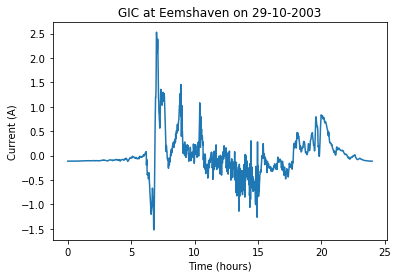

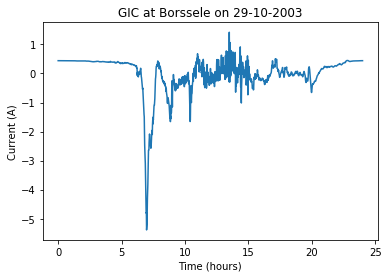

In [3]:
#plot one station's timeseries
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
path='/usr/people/out/Documents/Magnetic_field/station_results/new_29-10-2003'
os.system(f'ls {path}/GIC/*.csv > {path}/GIC.temp')
f=open(f'{path}/GIC.temp')

for counter,files in enumerate(f): #reading in data
    files=files.strip('\n')
    newdata=pd.read_csv(files, delimiter=';')
    numpydata=newdata.to_numpy()
    if counter==0:
        GIC_matrix=np.zeros((1440,len(numpydata)))
    GIC_matrix[counter,:]=numpydata[:,2]
os.system(f'rm {path}/GIC.temp')

Time=np.linspace(0,24,1440)
fig=plt.figure()
ax=fig.add_subplot(111)
ax.set_title('GIC at Eemshaven on 29-10-2003')
ax.set_ylabel('Current (A)')
ax.set_xlabel('Time (hours)')
ax.plot(Time,GIC_matrix[:,0])
plt.plot()
fig=plt.figure()
ax=fig.add_subplot(111)
ax.set_title('GIC at Borssele on 29-10-2003')
ax.set_ylabel('Current (A)')
ax.set_xlabel('Time (hours)')
ax.plot(Time,GIC_matrix[:,20])
plt.plot()

In [49]:
def ObtainJ(kabels,EX_matrix,EY_matrix,lat,lon,time,trafo_connect):
#     MEGACOUNTER=0
    localvar.cablecheck=np.zeros(len(kabels))
    localvar.E_kabels=np.zeros((len(kabels),2))         
    localvar.E_kabels=calcE(kabels,EX_matrix,EY_matrix,lat,lon,time)
    localvar.stat_voltN=np.zeros((len(trafo),len(trafo)))
    localvar.stat_voltE=np.zeros((len(trafo),len(trafo)))
    localvar.J_north=np.zeros(len(trafo))
    localvar.J_east=np.zeros(len(trafo))
    for localvar.row,localvar.line in enumerate(trafo_connect):
#         NEWCOUNTER=0
        ruleA=999
        for localvar.column,localvar.item in enumerate(localvar.line):
            if localvar.item:
                for localvar.number in range(len(kabels)):
                    localvar.cablecheck[localvar.number]=trafo_all_connections[localvar.row,localvar.number]+trafo_all_connections[localvar.column,localvar.number]
                localvar.A=np.array(np.where(localvar.cablecheck==2)) #find indices that indicate cables connected

                localvar.coord=trafo.at[localvar.row,'lat']
#                 print(localvar.row, localvar.column, localvar.coord, localvar.A, len(localvar.A[0]))
                for localvar.counter2 in range(len(localvar.A[0])): #double loop to check the cable connections
#                     NEWCOUNTER+=1
#                     MEGACOUNTER+=1
                    for localvar.counter in range(len(localvar.A[0])):
                        if abs(localvar.coord-kabels.at[localvar.A[0,localvar.counter],'strtlat'])<0.00001 and abs(ruleA-localvar.A[0,localvar.counter])>0.51: #check coord for which cable is connected and same cable is not allowed!
                            localvar.coord=kabels.at[localvar.A[0,localvar.counter],'eindlat']
                            ruleA=localvar.A[0,localvar.counter] #rule to ensure that the same cable is not picked again
#                             MEGACOUNTER+=1
#                             print(localvar.row,localvar.column, localvar.coord)
                            # first North component
                            if kabels.at[localvar.A[0,localvar.counter],'strtlat'] < kabels.at[localvar.A[0,localvar.counter],'eindlat']:
                                localvar.stat_voltN[localvar.row,localvar.column]+=localvar.E_kabels[localvar.A[0,localvar.counter],0]*-1
                            else:
                                localvar.stat_voltN[localvar.row,localvar.column]+=localvar.E_kabels[localvar.A[0,localvar.counter],0]
                            # now East component    
                            if kabels.at[localvar.A[0,localvar.counter],'strtlon'] < kabels.at[localvar.A[0,localvar.counter],'eindlon']:
                                localvar.stat_voltE[localvar.row,localvar.column]+=localvar.E_kabels[localvar.A[0,localvar.counter],1]*-1
                            else:
                                localvar.stat_voltE[localvar.row,localvar.column]+=localvar.E_kabels[localvar.A[0,localvar.counter],1]
                            break                           
                        elif abs(localvar.coord-kabels.at[localvar.A[0,localvar.counter],'eindlat'])<0.00001 and abs(ruleA-localvar.A[0,localvar.counter])>0.51:
                            ruleA=localvar.A[0,localvar.counter]
#                             MEGACOUNTER+=1
                            localvar.coord=kabels.at[localvar.A[0,localvar.counter],'strtlat']
#                             print(localvar.row, localvar.column, localvar.coord)
                            # first North component
                            if kabels.at[localvar.A[0,localvar.counter],'strtlat'] < kabels.at[localvar.A[0,localvar.counter],'eindlat']:
                                localvar.stat_voltN[localvar.row,localvar.column]+=localvar.E_kabels[localvar.A[0,localvar.counter],0]
                            else:
                                localvar.stat_voltN[localvar.row,localvar.column]+=localvar.E_kabels[localvar.A[0,localvar.counter],0]*-1
                            # now East component    
                            if kabels.at[localvar.A[0,localvar.counter],'strtlon'] < kabels.at[localvar.A[0,localvar.counter],'eindlon']:
                                localvar.stat_voltE[localvar.row,localvar.column]+=localvar.E_kabels[localvar.A[0,localvar.counter],1]
                            else:
                                localvar.stat_voltE[localvar.row,localvar.column]+=localvar.E_kabels[localvar.A[0,localvar.counter],1]*-1
                            break
                        else:
                            pass
#         print(localvar.row,NEWCOUNTER)
#     print(f'Amount of cables is {MEGACOUNTER/2}')
#                         else:
#                             print(localvar.row, localvar.column, 'error')
    for localvar.row,localvar.line in enumerate(trafo_connect):
        for localvar.column,localvar.item in enumerate(localvar.line):
            localvar.J_north[localvar.row]+=localvar.stat_voltN[localvar.row,localvar.column]*trafo_cond[localvar.row,localvar.column]*-1*-1 #extra -1 -1 to get J in opposite direction of E
            localvar.J_east[localvar.row]+=localvar.stat_voltE[localvar.row,localvar.column]*trafo_cond[localvar.row,localvar.column]*-1*-1
    return localvar.J_north, localvar.J_east

In [65]:
def calcE(kabels,EX_matrix,EY_matrix,lat,lon,time): #E for all cables
    from scipy.interpolate import griddata
    from scipy.integrate import simps
    localvar.heading=np.zeros(len(kabels))
    localvar.old=np.zeros((len(kabels),2))
    nr=40 # amount of nodes
    while True:
        localvar.E_all=np.zeros((len(kabels),2))
        localvar.latrange=np.zeros((len(kabels),nr))
        localvar.lonrange=np.zeros((len(kabels),nr))
        localvar.GridEX=np.zeros((len(kabels),nr))
        localvar.GridEY=np.zeros((len(kabels),nr))
    
        for number in range(len(kabels)):
            localvar.latrange[number,:]=np.linspace(kabels.at[number,'strtlat'],kabels.at[number,'eindlat'],nr) 
            localvar.lonrange[number,:]=np.linspace(kabels.at[number,'strtlon'],kabels.at[number,'eindlon'],nr) 
            localvar.heading[number]=kabels.at[number,'heading']
        localvar.GridEX=griddata((lat,lon),EX_matrix[time,:],(localvar.latrange,localvar.lonrange),method='cubic') #interpolate value
        localvar.GridEY=griddata((lat,lon),EY_matrix[time,:],(localvar.latrange,localvar.lonrange),method='cubic')
        for number in range(len(kabels)):
            localvar.E_all[number,0]+=abs(np.cos(np.radians(localvar.heading[number])))*simps(localvar.GridEX[number,:],np.linspace(0,kabels.at[number,'length'],nr))
            localvar.E_all[number,1]+=abs(np.sin(np.radians(localvar.heading[number])))*simps(localvar.GridEY[number,:],np.linspace(0,kabels.at[number,'length'],nr))
        print(nr, np.sum(abs(localvar.old-localvar.E_all)))
        if np.sum(abs(localvar.old-localvar.E_all))<10**-5:
            print('Iterations used', nr-1)
            break
        else:
            localvar.old[:,0]=localvar.E_all[:,0]
            localvar.old[:,1]=localvar.E_all[:,1]
            nr+=1
    return localvar.E_all

In [71]:
E_kabels=np.zeros((len(kabels),2))                
E_kabels=calcE(kabels,EX_matrix,EY_matrix,lat,lon,1300)
print(E_kabels)

40 57.69237599076081
41 6.037880696519738e-06
Iterations used 40
[[ 9.42989432e-02 -2.59435712e-02]
 [ 9.09133930e-02 -3.27485839e-02]
 [ 2.71771721e-02 -1.02343062e-01]
 [ 5.73622581e-03 -2.21413366e-02]
 [ 2.76492019e-01 -4.43910738e-02]
 [ 1.59124096e-01 -2.64502737e-01]
 [ 6.26773989e-02 -1.86281938e-01]
 [ 2.84316795e-02 -1.26957775e-01]
 [ 9.56468055e-02 -1.12319404e-03]
 [ 5.61500529e-02 -9.21788910e-02]
 [ 3.64343043e-02 -1.08769715e-01]
 [ 6.58213858e-02 -7.03802534e-02]
 [ 3.44236366e-02 -1.07759896e-01]
 [ 8.36973029e-02 -9.71910638e-03]
 [ 1.09022443e-01 -1.16574326e-01]
 [ 1.45181752e-01 -4.00805601e-02]
 [ 1.01071957e-01 -1.44107184e-01]
 [ 1.17449140e-01 -1.29551786e-02]
 [ 1.66805889e-01 -1.90974861e-01]
 [ 9.77903441e-02 -6.90703346e-02]
 [ 2.99573408e-02 -7.61307724e-02]
 [ 5.91673690e-02 -3.72928707e-02]
 [ 2.22537362e-02 -4.44619008e-02]
 [ 3.16024065e-02 -6.88697784e-02]
 [ 2.53981976e-03 -8.09633024e-02]
 [ 9.47024321e-02 -1.65202717e-01]
 [ 4.44072348e-02 -1.5331

In [48]:
J_kabels=np.zeros((len(kabels),2)) 
J_kabels=ObtainJ(kabels,EX_matrix,EY_matrix,lat,lon,0,trafo_connect)
print(J_kabels)

(array([ 6.64807950e-01, -2.28432112e-01,  2.26505246e-01, -3.36336218e-01,
       -4.09090009e-03,  1.67054919e-02, -4.01226829e-02,  2.09462860e-02,
        1.26084631e-02, -7.33703230e-03, -1.48097120e-02,  1.32798628e-02,
        2.78243519e-02, -8.58216400e-02, -2.06924192e-02,  5.44205351e-02,
       -8.08290429e-02,  6.28667603e-02,  6.05333152e-03,  1.72423421e-02,
        3.62372888e-03, -3.19700015e-03, -1.40500879e-02,  1.19398425e-02,
        1.06403497e-04,  1.31673838e-03, -2.04997910e-03,  5.75134529e-03,
       -4.70901703e-02,  1.30814430e-02, -2.72012212e-02,  1.31502155e-01,
        8.57156762e-02,  1.35005299e-01,  4.96681920e-02,  4.19791203e-02,
       -2.61268965e-02,  1.59340814e-01,  1.58829415e-03,  1.41339481e-01,
        2.40139163e-01, -2.54817492e-01,  4.57225782e-02, -9.22988568e-03,
        1.91198274e-02,  1.42482557e-03, -4.56265583e-02, -2.10574434e-02,
       -1.72963149e-02,  4.23533614e-02,  7.37569296e-02,  3.10551496e-02,
        2.35540068e-02, 

In [15]:
import os
import numpy as np
station=np.zeros(149)
cable=np.zeros(149)
ob_cable=np.zeros(149)
path='/usr/people/out/Documents'
f=open(f'{path}/original')
g=open(f'{path}/obtained_cable')
for counter,item in enumerate(f):
    item=item.split(' ')
    station[counter]=item[0]
    cable[counter]=item[1]
for counter,item in enumerate(g):
    item=item.split(' ')
    ob_cable[counter]=item[1]
    
for counter in range(149):
    if cable[counter]-ob_cable[counter] != 0:
        print(f'Hey, station {station[counter]} is incorrect, has now {ob_cable[counter]} cables, but should be {cable[counter]}!')
    else:
        print(f'{station[counter]} has no problems')

0.0 has no problems
1.0 has no problems
2.0 has no problems
3.0 has no problems
4.0 has no problems
5.0 has no problems
6.0 has no problems
7.0 has no problems
8.0 has no problems
9.0 has no problems
10.0 has no problems
11.0 has no problems
12.0 has no problems
13.0 has no problems
14.0 has no problems
15.0 has no problems
16.0 has no problems
17.0 has no problems
18.0 has no problems
19.0 has no problems
20.0 has no problems
21.0 has no problems
22.0 has no problems
23.0 has no problems
24.0 has no problems
25.0 has no problems
26.0 has no problems
27.0 has no problems
28.0 has no problems
29.0 has no problems
30.0 has no problems
31.0 has no problems
32.0 has no problems
33.0 has no problems
34.0 has no problems
35.0 has no problems
36.0 has no problems
Hey, station 37.0 is incorrect, has now 10.0 cables, but should be 11.0!
38.0 has no problems
39.0 has no problems
40.0 has no problems
41.0 has no problems
42.0 has no problems
43.0 has no problems
44.0 has no problems
45.0 has no p

In [ ]:
# obtain real voltages per cable piece and execute total code
import os
import pandas as pd
import numpy as np
import math
import logging
from scipy.interpolate import griddata
from threading import local
localvar=local()
from multiprocessing import Process
from multiprocessing import Lock
lock=Lock()
path='/nobackup/users/out/Magnetic_field/Halloweenx10'
plotday='Halloween storm'
logging.basicConfig(filename=f'{path}/GIClogbook.log', level=logging.DEBUG, format='%(asctime)s %(message)s')
#################################### first reading in datasets #####################################################
try:
    os.mkdir(f'{path}/GIC')
except:
    logging.warning("Directory has already been created, data could be destroyed!")
    print("Directory has already been created, data could be destroyed!")
logging.info('Reading in datasets!')
Electric_Xfiles=[]
Electric_Yfiles=[]
os.system(f' ls {path}/electric_field_north/*.csv > {path}/temp.txt')
f=open(f'{path}/temp.txt')
for item in f:
    item=item.strip('\n')
    Electric_Xfiles.append(item)
f.close()
os.system(f' ls {path}/electric_field_east/*.csv > {path}/temp.txt')
f=open(f'{path}/temp.txt')
for item in f:
    item=item.strip('\n')
    Electric_Yfiles.append(item)
f.close()
os.system(f'rm {path}/temp.txt')
logging.debug('Electric files created!')

for counter,file in enumerate(Electric_Xfiles):
    Xfile=pd.read_csv(file, delimiter=' ', header=None)
    values=Xfile.to_numpy()
    break
EX_matrix=np.zeros((len(Electric_Xfiles),len(values)))    
EY_matrix=np.zeros((len(Electric_Xfiles),len(values)))
logging.debug('Electric matrices have been made in memory!')

for counter,file in enumerate(Electric_Xfiles):
    Xfile=pd.read_csv(file, delimiter=' ', header=None)
    values=Xfile.to_numpy()
    EX_matrix[counter,:]=values[:,2]
logging.debug('EX_matrix has been made!')
lat=values[:,1]
lon=values[:,0]
for counter,file in enumerate(Electric_Yfiles):
    Yfile=pd.read_csv(file, delimiter=' ', header=None)
    values=Yfile.to_numpy()
    EY_matrix[counter,:]=values[:,2]
del item, f, Xfile, values, Yfile

######################################### Getting the needed GIC matrices and code #################################
logging.info('Starting with the GIC code!')
path2='/usr/people/out/Documents/380+220kV_extended'
kabels=pd.read_csv(path2+'/spreadsheetcables.csv', delimiter = ';')
trafo=pd.read_csv(path2+'/spreadsheettrafo.csv', delimiter = ';')
trafo_connect=np.zeros((len(trafo),len(trafo))) #connectivity trafo
trafo_all_connections=np.zeros((len(trafo),len(kabels))) #connections possible between trafo and every cable
trafo_cond=np.zeros((len(trafo),len(trafo))) # The conductivity matrix
stat_heading=np.zeros((len(trafo),len(trafo))) #heading stations to another
stat_length=np.zeros((len(trafo),len(trafo))) #length between stations
station_lat=np.zeros(len(trafo)) #latitude stations in degrees
station_lon=np.zeros(len(trafo)) #longitude stations in degrees
ground_cond=np.zeros(len(trafo))
cable_icon=np.zeros(len(kabels)) # icon array for cable and trafo resp.
trafo_icon=np.zeros(len(trafo))

##### connect trafo and cable number to position in matrix #####
for line in range(len(kabels)):
    cable_icon[line]=kabels.at[line,'kabelnr']
for line in range(len(trafo)):
    trafo_icon[line]=trafo.at[line,'trafonr']
##### make trafo-trafo connectivity matrix ######
for line in range(len(trafo)): 
    temp=trafo.at[line,'verbonden trafo'] #get right column
    temp=temp.split(",") #split values
    
    for item in temp:
        temp2=int(item)
        trafo_connect[line,np.where(trafo_icon == temp2)[0]]=True #check for connection other trafo
        del temp2
    del temp
###### make trafo-cable connectivity matrix ######
for line in range(len(trafo)):
    temp=trafo.at[line,'alle aansluitingen']
    temp=temp.split(",")
    for item in temp:
        temp2=int(item)
        trafo_all_connections[line,np.where(cable_icon == temp2)[0]]=True
        del temp2
    del temp
###### make conductivity matrix ######
for row,line in enumerate(trafo_connect):
    trafo_cond[row,row]=trafo.at[row,'conductivity total']
    for column,item in enumerate(line):
        if item:
            temp=trafo_all_connections[row,:]+trafo_all_connections[column,:]
            temp2=0
            for counter,value in enumerate(temp):
                if value == 2: # if 2 then we have found the connecting cables
                    temp2+=1/(float(kabels.at[counter,'conductivity'])*kabels.at[counter,'kab/3'])  #because of serieschain we have to add 1/sigma
#             if temp2==0:
#                 print(row,column)
            trafo_cond[row,column]=-1/temp2 #add cable resistance to off-diagonal
            trafo_cond[row,row]+=1/temp2 #add cable resistance to trace
            del temp, temp2
###### get heading and length between stations #####
for row,line in enumerate(trafo_connect):
    for column,item in enumerate(line):
        if item and column>=row:
            Alat=np.radians(trafo.at[row,'lat'])
            Alon=np.radians(trafo.at[row,'lon'])
            Blat=np.radians(trafo.at[column,'lat'])
            Blon=np.radians(trafo.at[column,'lon'])
            temp=math.cos(Blat)*math.sin(Blon-Alon)
            temp2=math.cos(Alat)*math.sin(Blat)-math.sin(Alat)*math.cos(Blat)*math.cos(Blon-Alon)
            stat_heading[row,column]=np.abs(math.degrees(math.atan(temp/temp2)))
            temp3=math.sin((Blat-Alat)/2.)**2+math.cos(Alat)*math.cos(Blat)*math.sin((Blon-Alon)/2.)**2
            stat_length[row,column]=6371000*2*math.atan(np.sqrt(temp3)/np.sqrt(1-temp3))
            stat_heading[column,row]=stat_heading[row,column]
            stat_length[column,row]=stat_length[row,column]
            del temp, temp2, temp3, Alat, Alon, Blat, Blon
del line, item, row, column, value, counter
######### get necessary arrays ########
for item in range(len(trafo)):
    station_lat[item]=trafo.at[item,'lat']
    station_lon[item]=trafo.at[item,'lon']
    ground_cond[item]=trafo.at[item,'conductivity total']

############################### Run the function with multiple processors ##########################################
logging.info('Start multiprocessing!')
print("New data is added now!")
n=6
nrsteps=int(1440*3/n)
threads=list()
for index in range(n):
    q=Process(target=GICfunction, args=(index+1,nrsteps*index,nrsteps*(index+1),trafo,EX_matrix,EY_matrix,lat,lon,station_lat,station_lon,trafo_connect,stat_heading,stat_length,trafo_cond,ground_cond,path,path2,kabels,trafo_all_connections,plotday))
    threads.append(q)
    q.start()
for thread in threads:
    thread.join()
logging.info("Script has been completed!")
print("Script has been completed!")

Directory has already been created, data could be destroyed!
New data is added now!


In [3]:
def GICfunction(q,begin,end,trafo,EX_matrix,EY_matrix,lat,lon,station_lat,station_lon,trafo_connect,stat_heading,stat_length,trafo_cond,ground_cond,path,path2,kabels,trafo_all_connections,plotday):

######################################### interpolation ############################################################
    localvar.volt_result=np.zeros(len(trafo))
    localvar.J_total=np.zeros(len(trafo))
    logging.info(f'Thread {q} has started interpolation!')
    for localvar.time in range(begin,end):#range(len(grid_EX)):
        localvar.J_north, localvar.J_east=ObtainJ(q,kabels,EX_matrix,EY_matrix,lat,lon,localvar.time,trafo_connect,trafo_all_connections,trafo_cond)
        localvar.J_total=localvar.J_north+localvar.J_east
        localvar.volt_result=np.linalg.solve(trafo_cond,localvar.J_total)
        localvar.I_GIC=localvar.volt_result*ground_cond
        
##################################### getting max I_GIC and writing results ########################################
        logging.info(f'Thread {q} is writing results to files for timestep {localvar.time}!')
        localvar.maxAMP=10
        if localvar.time<10:
            localvar.tijd=f'000{localvar.time}'
        elif localvar.time<100 and localvar.time>9:
            localvar.tijd=f'00{localvar.time}'
        elif localvar.time<1000 and localvar.time>99:
            localvar.tijd=f'0{localvar.time}'
        else:
            localvar.tijd=f'{localvar.time}'
        
        ##### Save files #######
        localvar.GIC=pd.DataFrame(columns=['lon','lat','GIC',f'GIC/{localvar.maxAMP}'])
        GICmatrix=pd.DataFrame()
        localvar.GIC.at[:,'lon']=station_lon
        localvar.GIC.at[:,'lat']=station_lat
        localvar.GIC.at[:,'GIC']=localvar.I_GIC
        localvar.GIC.at[:,f'GIC/{localvar.maxAMP}']=localvar.I_GIC/localvar.maxAMP
        localvar.GIC.to_csv(path_or_buf=f'{path}/GIC/GIC_{localvar.tijd}.csv', sep=';', index=False, header=True)
        
################################### Plotting results ###############################################################
        lim1=3.3
        lim2=7.5
        lim3=50.5
        lim4=54
        legendlon=lim1+0.18
        legendlat=lim4-0.1
        textlon=legendlon+0.40 #0.33
        textlat=legendlat-0.01

        with lock:
            legend=open(f'{path2}/legend.txt','w+')
            legend.write(f'{legendlon} {legendlat} 1 1')
            legend.close()
            legendtxt=open(f'{path2}/legendtext.txt', 'w+')
            legendtxt.write(f'{textlon} {textlat} {localvar.maxAMP}A')
            legendtxt.close()

            ##### Use GMT to plot GICs ######
            minute=localvar.time%60
            hour=int(localvar.time/60)%24
            DAY=int(localvar.time/(60*24))
            if minute < 10:
                minute=f'0{minute}'
            if hour < 10:
                hour=f'0{hour}'
            
            title=f'GIC at {plotday} - {DAY}:{hour}:{minute}'
            proj='-JM15C -P'
            lims=f'-R{lim1}/{lim2}/{lim3}/{lim4}'
            psfile=f'{path}/GIC/GIC_at_{localvar.tijd}.ps' #aanpassen
            pngfile=f'{path}/GIC/GIC_at_{localvar.tijd}.png' #aanpassen
            os.system(f'gmt pscoast {proj} {lims} -W0.5p -K -Ggrey -Slightblue -Df -N1/0.25p> {psfile}' )
            os.system(f'gmt psbasemap {proj} {lims} -Ba1g1 -BWeSn+t"{title}" -O -K>> {psfile}' )
            os.system(f'gmt psxy {path2}/cables.csv {proj} {lims} -W0.5p -Wred -O -K>> {psfile}' )
            os.system(f'gmt psxy {path}/GIC/GIC_{localvar.tijd}.csv {proj} {lims} -Ctopo.cpt -Scc -O -K>> {psfile}')    
            os.system(f'gmt psxy {path2}/legend.txt {proj} {lims} -Ctopo.cpt -W -Scc -O -K>> {psfile}')
            os.system(f'gmt pstext {path2}/legendtext.txt {proj} {lims} -F+f30pHelvetica,black -O>> {psfile}')
        os.system(f'convert -density 300 {psfile} {pngfile}')
        os.system(f'rm {psfile}')
        logging.info(f'Thread {q} has fulfilled timestep {localvar.time}!')
    logging.info(f'Thread {q} is finished!')

In [2]:
def ObtainJ(q,kabels,EX_matrix,EY_matrix,lat,lon,time,trafo_connect,trafo_all_connections,trafo_cond):
    localvar.cablecheck=np.zeros(len(kabels))
    localvar.E_kabels=np.zeros((len(kabels),2))      
    logging.info(f'Thread {q} has started integration procedure!')
    localvar.E_kabels=calcE(kabels,EX_matrix,EY_matrix,lat,lon,time)
    logging.info(f'Thread {q} has finished integration procedure and is now writing results!')
    localvar.stat_voltN=np.zeros((len(trafo_connect),len(trafo_connect)))
    localvar.stat_voltE=np.zeros((len(trafo_connect),len(trafo_connect)))
    localvar.J_north=np.zeros(len(trafo_connect))
    localvar.J_east=np.zeros(len(trafo_connect))
    for localvar.row,localvar.line in enumerate(trafo_connect):
        ruleA=999
        for localvar.column,localvar.item in enumerate(localvar.line):
            if localvar.item:
                for localvar.number in range(len(kabels)):
                    localvar.cablecheck[localvar.number]=trafo_all_connections[localvar.row,localvar.number]+trafo_all_connections[localvar.column,localvar.number]
                localvar.A=np.array(np.where(localvar.cablecheck==2)) #find indices that indicate cables connected

                localvar.coord=trafo.at[localvar.row,'lat']
                for localvar.counter2 in range(len(localvar.A[0])): #double loop to check the cable connections
                    for localvar.counter in range(len(localvar.A[0])):
                        if abs(localvar.coord-kabels.at[localvar.A[0,localvar.counter],'strtlat'])<0.00001 and abs(ruleA-localvar.A[0,localvar.counter])>0.51: #check coord for which cable is connected and same cable is not allowed!
                            localvar.coord=kabels.at[localvar.A[0,localvar.counter],'eindlat']
                            ruleA=localvar.A[0,localvar.counter] #rule to ensure that the same cable is not picked again
                            
                            # first North component
                            if kabels.at[localvar.A[0,localvar.counter],'strtlat'] < kabels.at[localvar.A[0,localvar.counter],'eindlat']:
                                localvar.stat_voltN[localvar.row,localvar.column]+=localvar.E_kabels[localvar.A[0,localvar.counter],0]*-1
                            else:
                                localvar.stat_voltN[localvar.row,localvar.column]+=localvar.E_kabels[localvar.A[0,localvar.counter],0]
                            # now East component    
                            if kabels.at[localvar.A[0,localvar.counter],'strtlon'] < kabels.at[localvar.A[0,localvar.counter],'eindlon']:
                                localvar.stat_voltE[localvar.row,localvar.column]+=localvar.E_kabels[localvar.A[0,localvar.counter],1]*-1
                            else:
                                localvar.stat_voltE[localvar.row,localvar.column]+=localvar.E_kabels[localvar.A[0,localvar.counter],1]
                            break                           
                        elif abs(localvar.coord-kabels.at[localvar.A[0,localvar.counter],'eindlat'])<0.00001 and abs(ruleA-localvar.A[0,localvar.counter])>0.51:
                            ruleA=localvar.A[0,localvar.counter]
                            localvar.coord=kabels.at[localvar.A[0,localvar.counter],'strtlat']

                            # first North component
                            if kabels.at[localvar.A[0,localvar.counter],'strtlat'] < kabels.at[localvar.A[0,localvar.counter],'eindlat']:
                                localvar.stat_voltN[localvar.row,localvar.column]+=localvar.E_kabels[localvar.A[0,localvar.counter],0]
                            else:
                                localvar.stat_voltN[localvar.row,localvar.column]+=localvar.E_kabels[localvar.A[0,localvar.counter],0]*-1
                            # now East component    
                            if kabels.at[localvar.A[0,localvar.counter],'strtlon'] < kabels.at[localvar.A[0,localvar.counter],'eindlon']:
                                localvar.stat_voltE[localvar.row,localvar.column]+=localvar.E_kabels[localvar.A[0,localvar.counter],1]
                            else:
                                localvar.stat_voltE[localvar.row,localvar.column]+=localvar.E_kabels[localvar.A[0,localvar.counter],1]*-1
                            break
                        else:
                            pass

            localvar.J_north[localvar.row]+=localvar.stat_voltN[localvar.row,localvar.column]*trafo_cond[localvar.row,localvar.column]*-1*-1 #extra -1 -1 to get J in opposite direction of E
            localvar.J_east[localvar.row]+=localvar.stat_voltE[localvar.row,localvar.column]*trafo_cond[localvar.row,localvar.column]*-1*-1
    return localvar.J_north, localvar.J_east

In [1]:
def calcE(kabels,EX_matrix,EY_matrix,lat,lon,time): #E for all cables
    from scipy.interpolate import griddata
    from scipy.integrate import simps
    localvar.heading=np.zeros(len(kabels))
    localvar.old=np.zeros((len(kabels),2))
    nr=40 # amount of nodes
    while True:
        localvar.E_all=np.zeros((len(kabels),2))
        localvar.latrange=np.zeros((len(kabels),nr))
        localvar.lonrange=np.zeros((len(kabels),nr))
        localvar.GridEX=np.zeros((len(kabels),nr))
        localvar.GridEY=np.zeros((len(kabels),nr))
    
        for number in range(len(kabels)):
            localvar.latrange[number,:]=np.linspace(kabels.at[number,'strtlat'],kabels.at[number,'eindlat'],nr) 
            localvar.lonrange[number,:]=np.linspace(kabels.at[number,'strtlon'],kabels.at[number,'eindlon'],nr) 
            localvar.heading[number]=kabels.at[number,'heading']
        localvar.GridEX=griddata((lat,lon),EX_matrix[time,:],(localvar.latrange,localvar.lonrange),method='cubic') #interpolate value
        localvar.GridEY=griddata((lat,lon),EY_matrix[time,:],(localvar.latrange,localvar.lonrange),method='cubic')
        for number in range(len(kabels)):
            localvar.E_all[number,0]+=abs(np.cos(np.radians(localvar.heading[number])))*simps(localvar.GridEX[number,:],np.linspace(0,kabels.at[number,'length'],nr))
            localvar.E_all[number,1]+=abs(np.sin(np.radians(localvar.heading[number])))*simps(localvar.GridEY[number,:],np.linspace(0,kabels.at[number,'length'],nr))

        if np.sum(abs(localvar.old-localvar.E_all))<10**-5:
            logging.info(f'{nr-39} iterations were used for time={time}')
            break
        else:
            localvar.old[:,0]=localvar.E_all[:,0]
            localvar.old[:,1]=localvar.E_all[:,1]
            nr+=1
    return localvar.E_all

In [ ]:
import os
path='/nobackup/users/out/Magnetic_field/Halloweenx10'
os.system(f'ffmpeg -framerate 24 -pattern_type glob -i "{path}/GIC/GIC_at_????.png" {path}/GIC_Halloween.mp4')

In [ ]:
import os
os.system("shutdown now")

In [1]:
# plot timelapse GIC
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

#reading in all GIC files
path='/nobackup/users/out/Magnetic_field/Halloweenx10'
path2='/usr/people/out/Documents/380+220kV_extended'
os.system(f"ls {path}/GIC/GIC_????.csv > {path}/temp.txt")
f=open(f"{path}/temp.txt")
string=[]

A=np.arange(3,21)
B=np.arange(46,54,1)
stationlist=np.hstack([0,1,A,28,29,32,33,35,43,44,B])

GIC_data=np.zeros((1440*3,149))

for item in f:
    item=item.rstrip('\n')
    string.append(item)
string=sorted(string)
for counter,time in enumerate(string):
    GIC_file=pd.read_csv(time, delimiter=';')
    GIC=GIC_file.to_numpy()
    GIC_data[counter]=GIC[:,2]

os.system(f'rm {path}/temp.txt')
   
stationframe=pd.read_csv(f'{path2}/spreadsheettrafo.csv', delimiter=';')
 
plt.rcParams.update({'font.size': 14}) 
timevector=np.linspace(0,72,1440*3)
fig1=plt.figure(figsize=(20,15))
ax1=fig1.add_subplot()
ax1.set_title('GIC during Halloween storm (29-31 October 2003)')
ax1.set_ylabel('GIC (A)')
ax1.set_xlabel('Time (hours)')
for station in stationlist:
    ax1.plot(timevector,GIC_data[:,station],label=stationframe.at[station,'naam'])
# plt.subplots_adjust(left=0)
lgd=ax1.legend(bbox_to_anchor=(1.01,1))
plt.savefig(f'{path}/GIC_allstationsnew.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

19 [  7680.  21120.  34560.  48000.  61440.  74880.  88320. 101760. 115200.
 128640. 142080. 155520. 168960. 182400. 195840. 209280. 222720. 236160.
 249600.]


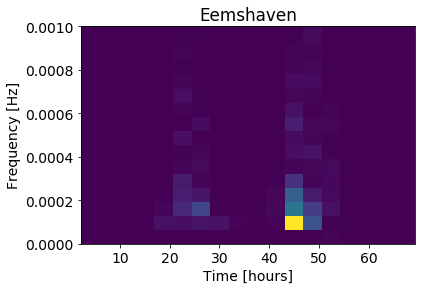

19 [  7680.  21120.  34560.  48000.  61440.  74880.  88320. 101760. 115200.
 128640. 142080. 155520. 168960. 182400. 195840. 209280. 222720. 236160.
 249600.]


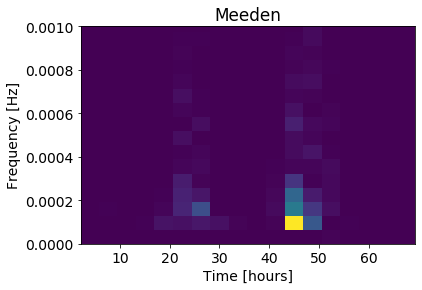

19 [  7680.  21120.  34560.  48000.  61440.  74880.  88320. 101760. 115200.
 128640. 142080. 155520. 168960. 182400. 195840. 209280. 222720. 236160.
 249600.]


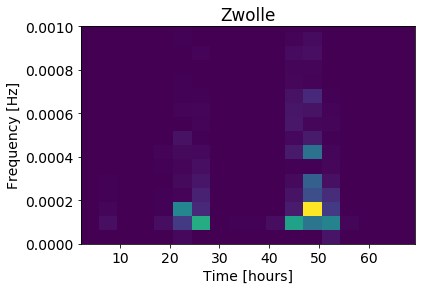

19 [  7680.  21120.  34560.  48000.  61440.  74880.  88320. 101760. 115200.
 128640. 142080. 155520. 168960. 182400. 195840. 209280. 222720. 236160.
 249600.]


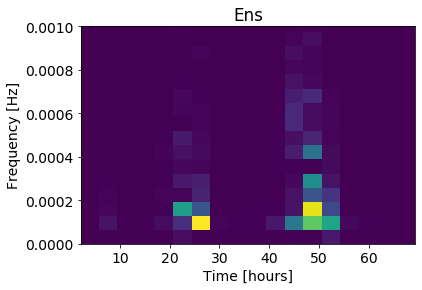

19 [  7680.  21120.  34560.  48000.  61440.  74880.  88320. 101760. 115200.
 128640. 142080. 155520. 168960. 182400. 195840. 209280. 222720. 236160.
 249600.]


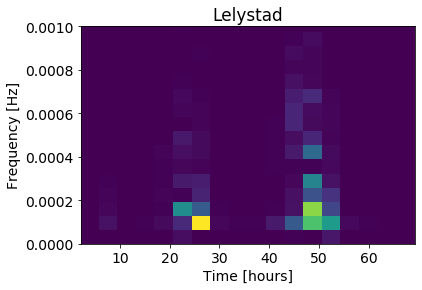

19 [  7680.  21120.  34560.  48000.  61440.  74880.  88320. 101760. 115200.
 128640. 142080. 155520. 168960. 182400. 195840. 209280. 222720. 236160.
 249600.]


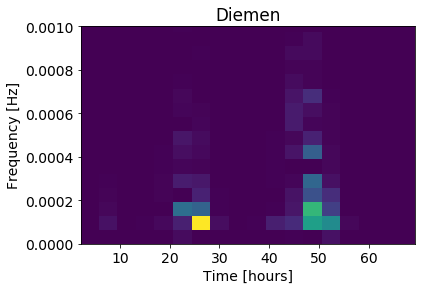

19 [  7680.  21120.  34560.  48000.  61440.  74880.  88320. 101760. 115200.
 128640. 142080. 155520. 168960. 182400. 195840. 209280. 222720. 236160.
 249600.]


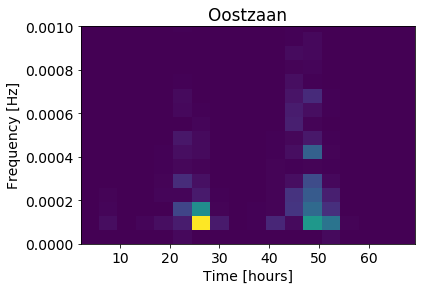

19 [  7680.  21120.  34560.  48000.  61440.  74880.  88320. 101760. 115200.
 128640. 142080. 155520. 168960. 182400. 195840. 209280. 222720. 236160.
 249600.]


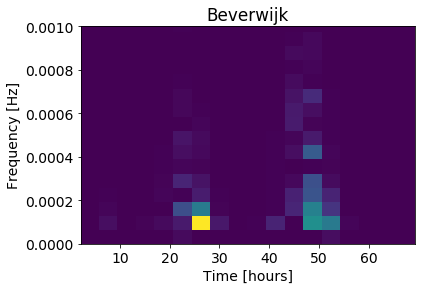

19 [  7680.  21120.  34560.  48000.  61440.  74880.  88320. 101760. 115200.
 128640. 142080. 155520. 168960. 182400. 195840. 209280. 222720. 236160.
 249600.]


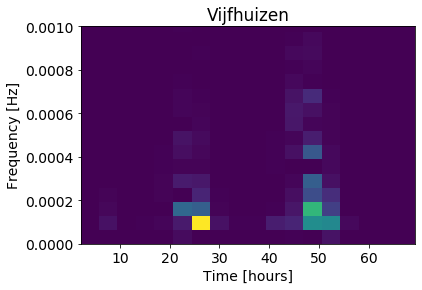

19 [  7680.  21120.  34560.  48000.  61440.  74880.  88320. 101760. 115200.
 128640. 142080. 155520. 168960. 182400. 195840. 209280. 222720. 236160.
 249600.]


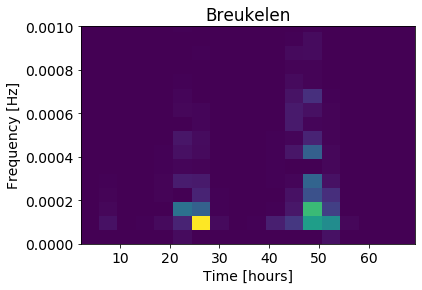

19 [  7680.  21120.  34560.  48000.  61440.  74880.  88320. 101760. 115200.
 128640. 142080. 155520. 168960. 182400. 195840. 209280. 222720. 236160.
 249600.]


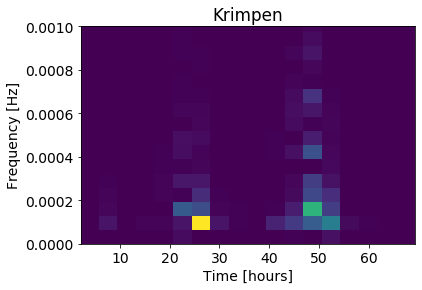

19 [  7680.  21120.  34560.  48000.  61440.  74880.  88320. 101760. 115200.
 128640. 142080. 155520. 168960. 182400. 195840. 209280. 222720. 236160.
 249600.]


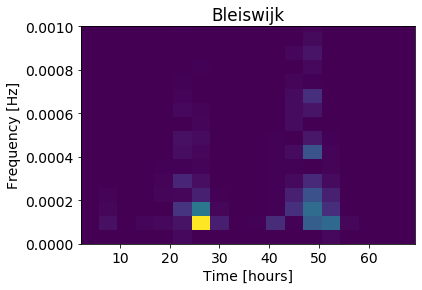

19 [  7680.  21120.  34560.  48000.  61440.  74880.  88320. 101760. 115200.
 128640. 142080. 155520. 168960. 182400. 195840. 209280. 222720. 236160.
 249600.]


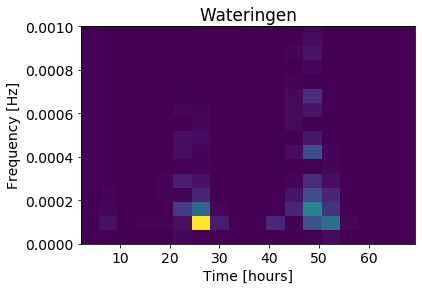

19 [  7680.  21120.  34560.  48000.  61440.  74880.  88320. 101760. 115200.
 128640. 142080. 155520. 168960. 182400. 195840. 209280. 222720. 236160.
 249600.]


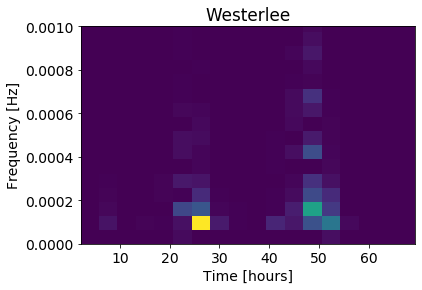

19 [  7680.  21120.  34560.  48000.  61440.  74880.  88320. 101760. 115200.
 128640. 142080. 155520. 168960. 182400. 195840. 209280. 222720. 236160.
 249600.]


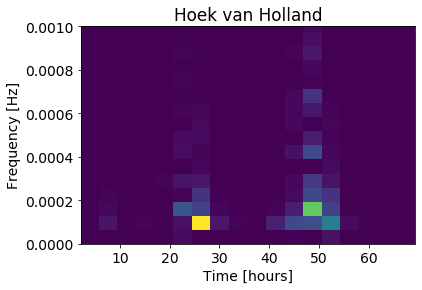

19 [  7680.  21120.  34560.  48000.  61440.  74880.  88320. 101760. 115200.
 128640. 142080. 155520. 168960. 182400. 195840. 209280. 222720. 236160.
 249600.]


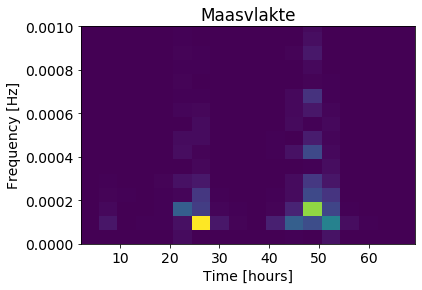

19 [  7680.  21120.  34560.  48000.  61440.  74880.  88320. 101760. 115200.
 128640. 142080. 155520. 168960. 182400. 195840. 209280. 222720. 236160.
 249600.]


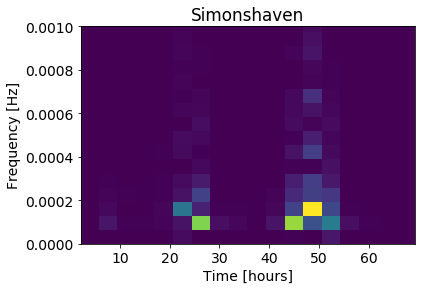

19 [  7680.  21120.  34560.  48000.  61440.  74880.  88320. 101760. 115200.
 128640. 142080. 155520. 168960. 182400. 195840. 209280. 222720. 236160.
 249600.]


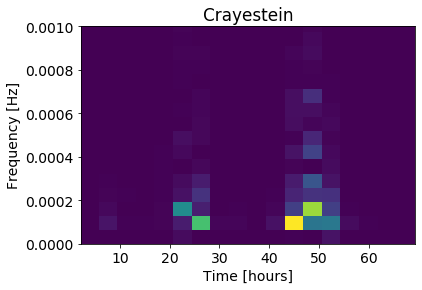

19 [  7680.  21120.  34560.  48000.  61440.  74880.  88320. 101760. 115200.
 128640. 142080. 155520. 168960. 182400. 195840. 209280. 222720. 236160.
 249600.]


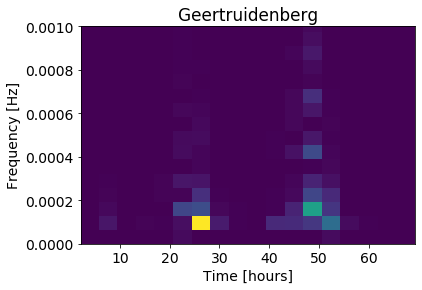

19 [  7680.  21120.  34560.  48000.  61440.  74880.  88320. 101760. 115200.
 128640. 142080. 155520. 168960. 182400. 195840. 209280. 222720. 236160.
 249600.]


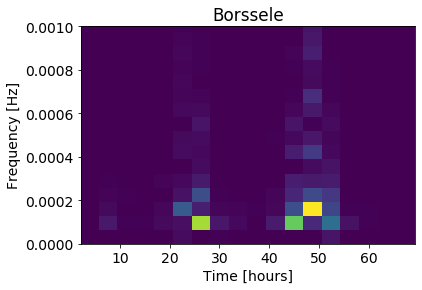

19 [  7680.  21120.  34560.  48000.  61440.  74880.  88320. 101760. 115200.
 128640. 142080. 155520. 168960. 182400. 195840. 209280. 222720. 236160.
 249600.]


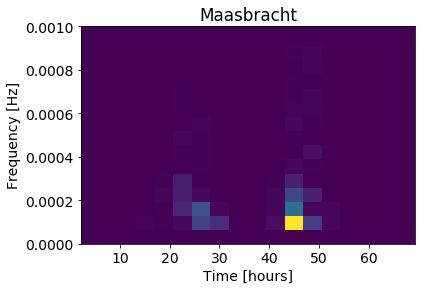

19 [  7680.  21120.  34560.  48000.  61440.  74880.  88320. 101760. 115200.
 128640. 142080. 155520. 168960. 182400. 195840. 209280. 222720. 236160.
 249600.]


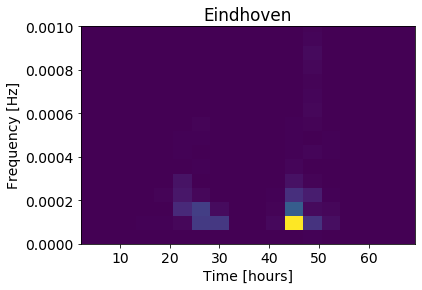

19 [  7680.  21120.  34560.  48000.  61440.  74880.  88320. 101760. 115200.
 128640. 142080. 155520. 168960. 182400. 195840. 209280. 222720. 236160.
 249600.]


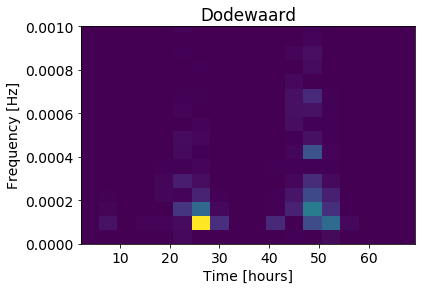

19 [  7680.  21120.  34560.  48000.  61440.  74880.  88320. 101760. 115200.
 128640. 142080. 155520. 168960. 182400. 195840. 209280. 222720. 236160.
 249600.]


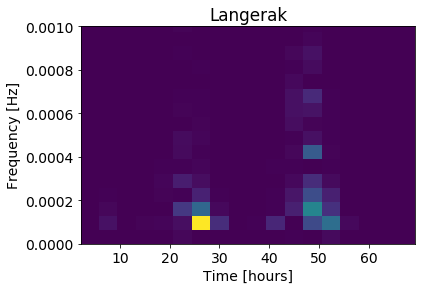

19 [  7680.  21120.  34560.  48000.  61440.  74880.  88320. 101760. 115200.
 128640. 142080. 155520. 168960. 182400. 195840. 209280. 222720. 236160.
 249600.]


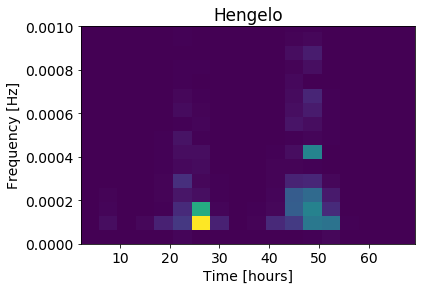

19 [  7680.  21120.  34560.  48000.  61440.  74880.  88320. 101760. 115200.
 128640. 142080. 155520. 168960. 182400. 195840. 209280. 222720. 236160.
 249600.]


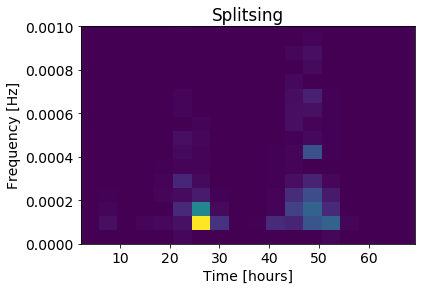

19 [  7680.  21120.  34560.  48000.  61440.  74880.  88320. 101760. 115200.
 128640. 142080. 155520. 168960. 182400. 195840. 209280. 222720. 236160.
 249600.]


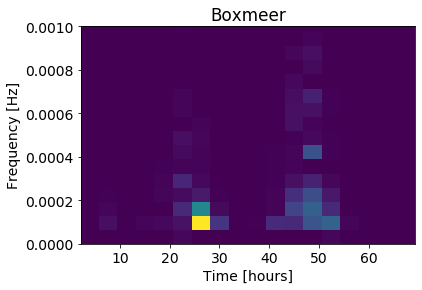

19 [  7680.  21120.  34560.  48000.  61440.  74880.  88320. 101760. 115200.
 128640. 142080. 155520. 168960. 182400. 195840. 209280. 222720. 236160.
 249600.]


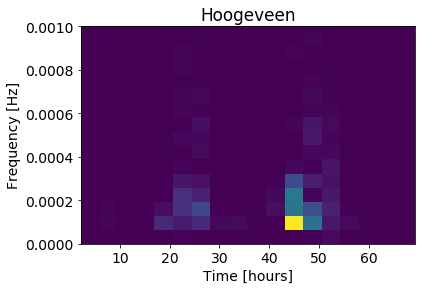

19 [  7680.  21120.  34560.  48000.  61440.  74880.  88320. 101760. 115200.
 128640. 142080. 155520. 168960. 182400. 195840. 209280. 222720. 236160.
 249600.]


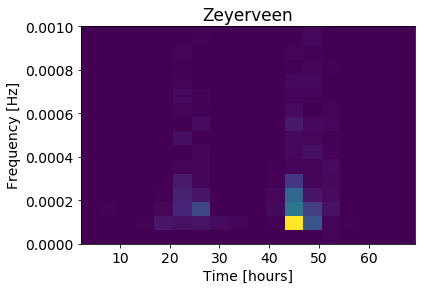

19 [  7680.  21120.  34560.  48000.  61440.  74880.  88320. 101760. 115200.
 128640. 142080. 155520. 168960. 182400. 195840. 209280. 222720. 236160.
 249600.]


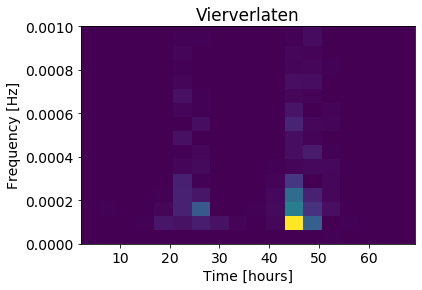

19 [  7680.  21120.  34560.  48000.  61440.  74880.  88320. 101760. 115200.
 128640. 142080. 155520. 168960. 182400. 195840. 209280. 222720. 236160.
 249600.]


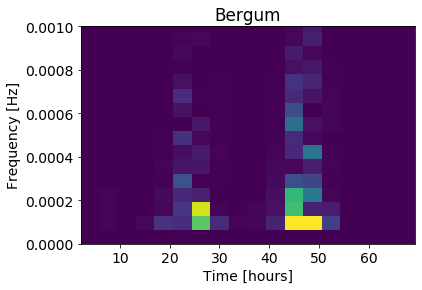

19 [  7680.  21120.  34560.  48000.  61440.  74880.  88320. 101760. 115200.
 128640. 142080. 155520. 168960. 182400. 195840. 209280. 222720. 236160.
 249600.]


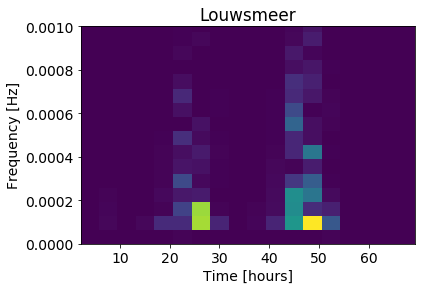

19 [  7680.  21120.  34560.  48000.  61440.  74880.  88320. 101760. 115200.
 128640. 142080. 155520. 168960. 182400. 195840. 209280. 222720. 236160.
 249600.]


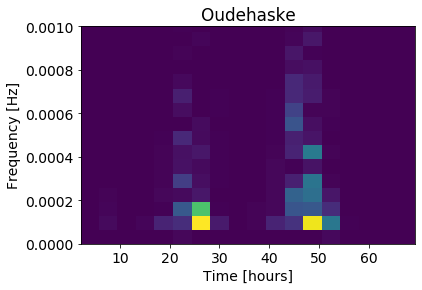

19 [  7680.  21120.  34560.  48000.  61440.  74880.  88320. 101760. 115200.
 128640. 142080. 155520. 168960. 182400. 195840. 209280. 222720. 236160.
 249600.]


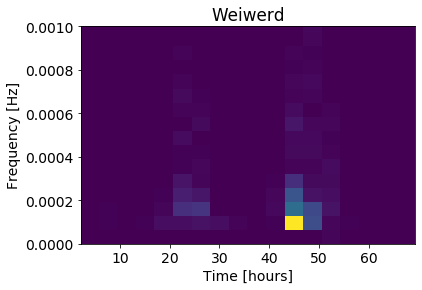

19 [  7680.  21120.  34560.  48000.  61440.  74880.  88320. 101760. 115200.
 128640. 142080. 155520. 168960. 182400. 195840. 209280. 222720. 236160.
 249600.]


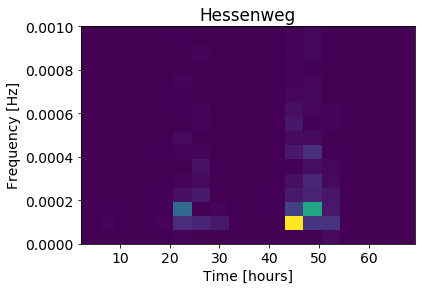

In [52]:
# get time-frequency plot
fs=1/(60.)
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

for station in stationlist:
    f,t,z=spectrogram(GIC_data[:,station],fs)
    print(len(t),t)
    plt.pcolormesh(t/3600, f, z)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [hours]')
    plt.title(stationframe.at[station,'naam'])
    plt.axis(ymin=0, ymax=10**-3)
    plt.show()

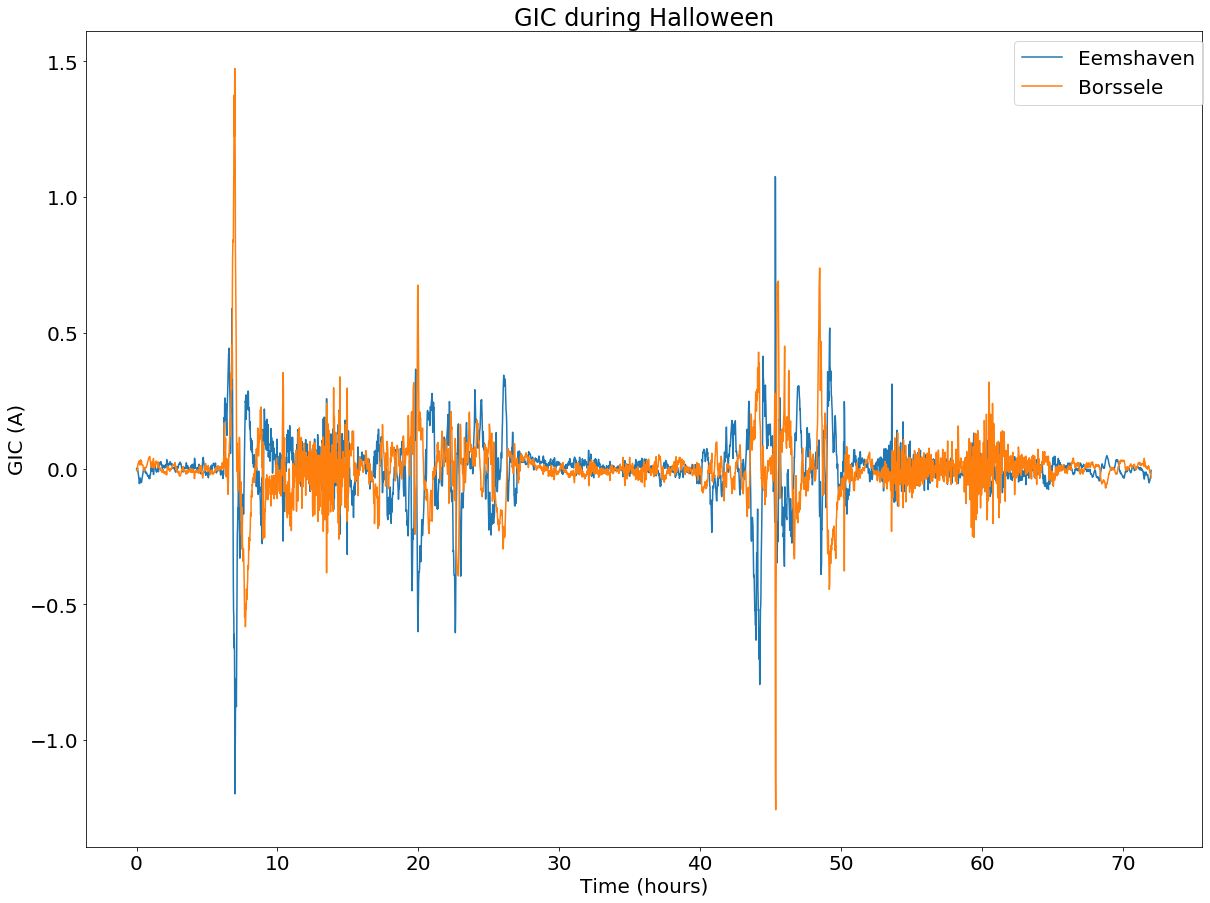

In [10]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
respath='/nobackup/users/out/Magnetic_field'
days='Halloween/model7'
day=3
lentrafo=149
netpath='/usr/people/out/Documents/380+220kV_extended'
stationlist=[0,20]

#reading in all GIC files
os.system(f"ls {respath}/{days}/GIC/GIC_????.csv > {respath}/{days}/temp.txt")
f=open(f"{respath}/{days}/temp.txt")
string=[]

GIC_data=np.zeros((1440*day,lentrafo))

for item in f:
    item=item.rstrip('\n')
    string.append(item)
string=sorted(string)
for counter,time in enumerate(string):
    GIC_file=pd.read_csv(time, delimiter=';')
    GIC=GIC_file.to_numpy()
    GIC_data[counter]=GIC[:,2]

os.system(f'rm {respath}/{day}/temp.txt')

stationframe=pd.read_csv(f'{netpath}/spreadsheettrafo.csv', delimiter=';')

plt.rcParams.update({'font.size': 20}) 
timevector=np.linspace(0,24*day,1440*day)
fig1=plt.figure(figsize=(20,15))
ax1=fig1.add_subplot()
ax1.set_title(f'GIC during Halloween')
ax1.set_ylabel('GIC (A)')
ax1.set_xlabel('Time (hours)')
for station in stationlist:
    ax1.plot(timevector,GIC_data[:,station],label=stationframe.at[station,'naam'])
# plt.subplots_adjust(left=0)
lgd=ax1.legend(bbox_to_anchor=(1.01,1))
plt.savefig(f'{respath}/{days}/GIC_Borssele.png', bbox_extra_artists=(lgd,), bbox_inches='tight')